In [1]:
# Import necessary libraries
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
pd.set_option('future.no_silent_downcasting', True)  # Suppress warnings for future downcasting in pandas

import seaborn as sns  # For data visualization
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
# train_test_split: Splits data into training and testing sets
# StratifiedKFold: Ensures balanced class distributions in cross-validation splits
# cross_val_score: Evaluates model performance using cross-validation
# GridSearchCV: Hyperparameter tuning using grid search with cross-validation

from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors Classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier
from sklearn.metrics import accuracy_score  # For calculating the accuracy of predictions
from sklearn.preprocessing import LabelEncoder, StandardScaler
# LabelEncoder: Encodes target labels with value between 0 and n_classes-1
# StandardScaler: Standardizes features by removing the mean and scaling to unit variance

from xgboost import XGBClassifier  # Extreme Gradient Boosting Classifier
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import shap  # For SHAP (SHapley Additive exPlanations) values, used for model interpretability
import joblib  # For saving and loading machine learning models

## Import data

In [2]:
# Load the datasets
train_data = pd.read_csv('Data/Loan_dataset_train.csv') # This is the portion of the dataset used to "train" or fit the model.
test_data = pd.read_csv('Data/Loan_dataset_test.csv') # Test data serves as the unseen dataset

In [3]:
# Display the first few rows of the training dataset
print("Training Data Head:")
train_data.head()

Training Data Head:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# Display the first few rows of the test dataset
print("\nTest Data Head:")
test_data.head()


Test Data Head:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Understanding the data

In [5]:
# Data columns
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

There are 12 independent variables and 1 target variable, i.e., `Loan_Status`

In [6]:
# Data columns
test_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

The test dataset contains the same features as the training dataset, except for `Loan_Status`. The model will be trained on the training data to predict `Loan_Status` for the test dataset.

The description of each variable is provided below.

| Variable           | Description                                  |
|--------------------|----------------------------------------------|
| Loan_ID            | Unique Loan ID                               |
| Gender             | Male/ Female                                 |
| Married            | Applicant married (Y/N)                      |
| Dependents         | Number of dependents                         |
| Education          | Applicant Education (Graduate/Under Graduate)|
| Self_Employed      | Self employed (Y/N)                          |
| ApplicantIncome    | Applicant income                             |
| CoapplicantIncome  | Coapplicant income                           |
| LoanAmount         | Loan amount in thousands                     |
| Loan_Amount_Term   | Term of loan in months                       |
| Credit_History     | Creof individual’s repayment of their debts guidelines              |
| Property_Area      | Urban/ Semi Urban/ Rural                     |
| Loan_Status        | Loan approved (Y/N)                          |


In [7]:
# Dataset shape
train_data.shape, test_data.shape

((614, 13), (367, 12))

The training dataset contains 614 rows and 13 columns, while the test dataset includes 367 rows and 12 columns.

In [8]:
# Remove the Loan_ID variable since it doesn't impact the loan status. 
train_data = train_data.drop('Loan_ID', axis=1)
test_data = test_data.drop('Loan_ID', axis=1)

## Feature Engineering

To enhance the model's predictive power, new features are introduced based on domain knowledge (for more details see, e.g., these two conference papers [[1]](https://doi.org/10.1051/itmconf/20224403019) and [[2]](https://link.springer.com/chapter/10.1007/978-981-99-0601-7_14)). These features are designed to influence the target variable, loan approval likelihood, as follows:

1. **Total Income**  
   - By combining the `Applicant Income` and `Co-applicant Income`, we create a `Total Income` feature. Higher total income may correlate with a higher probability of loan approval, as it indicates greater financial capability. 

2. **EMI (Equated Monthly Installment)**  
   - EMI represents the fixed monthly payment required to repay the loan over the specified term. EMI is the ratio of the loan amount to the loan term. Applicants with a high EMI might experience more financial strain, potentially lowering their ability to keep up with payments.

3. **Balance Income**  
   - This feature captures the income remaining after the EMI has been deducted. We hypothesize that a higher balance income enhances the likelihood of loan repayment, as it suggests sufficient funds are available even after covering loan payments, increasing the chances of loan approval.

In [9]:
# Total Income
train_data['Total_Income']=train_data['ApplicantIncome']+train_data['CoapplicantIncome']
test_data['Total_Income']=test_data['ApplicantIncome']+test_data['CoapplicantIncome']

# EMI
train_data['EMI']=train_data['LoanAmount']/train_data['Loan_Amount_Term'] 
test_data['EMI']=test_data['LoanAmount']/test_data['Loan_Amount_Term']

# Balance Income
train_data['Balance_Income']=train_data['Total_Income']-(train_data['EMI']*1000) 
test_data['Balance_Income']=test_data['Total_Income']-(test_data['EMI']*1000)

In [10]:
# Copy of the data
train_data_original = train_data.copy()
test_data_original = test_data.copy()

Remove the variables used to create these new features, as they will likely be highly correlated with the new features. 

In [11]:
train_data=train_data.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)
test_data=test_data.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

## Data Exploration
Expanding on the exploratory analysis will allow to better understand the data distribution, feature relationships, and key patterns.

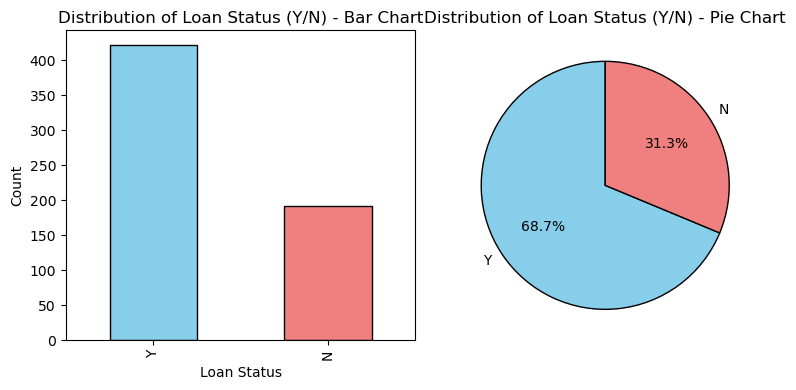

In [12]:
# Bar chart and pie chart
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Bar chart for 'Loan_Status' distribution

# Counting the values for 'Loan_Status'
loan_status_counts = train_data['Loan_Status'].value_counts()
# Calculating percentages for pie chart
total = loan_status_counts.sum()
loan_status_percentages = (loan_status_counts / total) * 100

loan_status_counts.plot.bar(ax=axes[0], color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0].set_title('Distribution of Loan Status (Y/N) - Bar Chart')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')

# Pie chart for 'Loan_Status' distribution
axes[1].pie(loan_status_percentages, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90, 
            colors=['skyblue', 'lightcoral'], wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Distribution of Loan Status (Y/N) - Pie Chart')

# Displaying the combined plot
plt.tight_layout()
plt.show()

The distribution plot shows that the target variable, `Loan_Status`, has more approved loans (labeled as Y) than disapproved ones (labeled as N). 68.7% had received loan approval, while 31.3% were rejected.

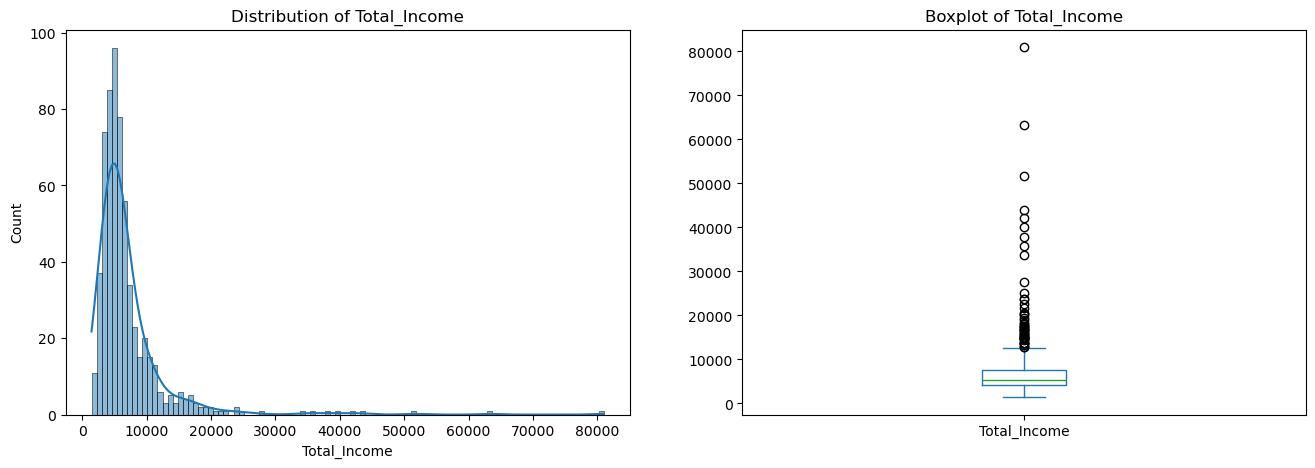

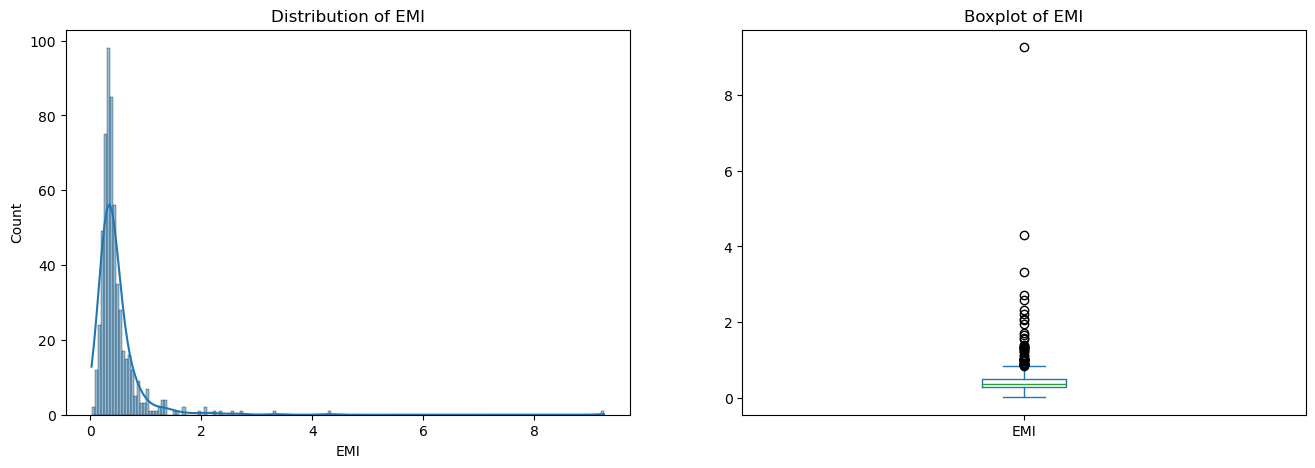

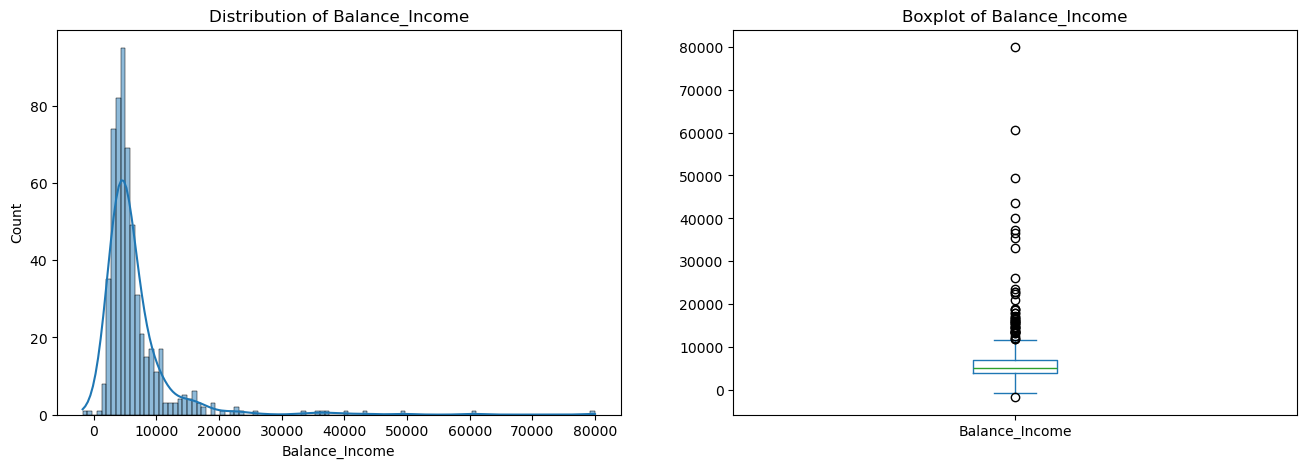

In [13]:
# Distributions of numerical features

# List of numerical columns
numerical_columns = ['Total_Income', 'EMI', 'Balance_Income'] 

# Loop through each column to create distribution and boxplots
for column in numerical_columns:
    plt.figure(figsize=(16, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[column], kde=True)  
    plt.title(f'Distribution of {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    train_data[column].plot.box()
    plt.title(f'Boxplot of {column}')
    
    plt.show()

The histograms show that their distribution are right-skewed, indicating that a few applicants have significantly higher incomes than others. This skewness might necessitate scaling or transformation for more effective modeling. There are also some outliers that will be addressed in later sections.

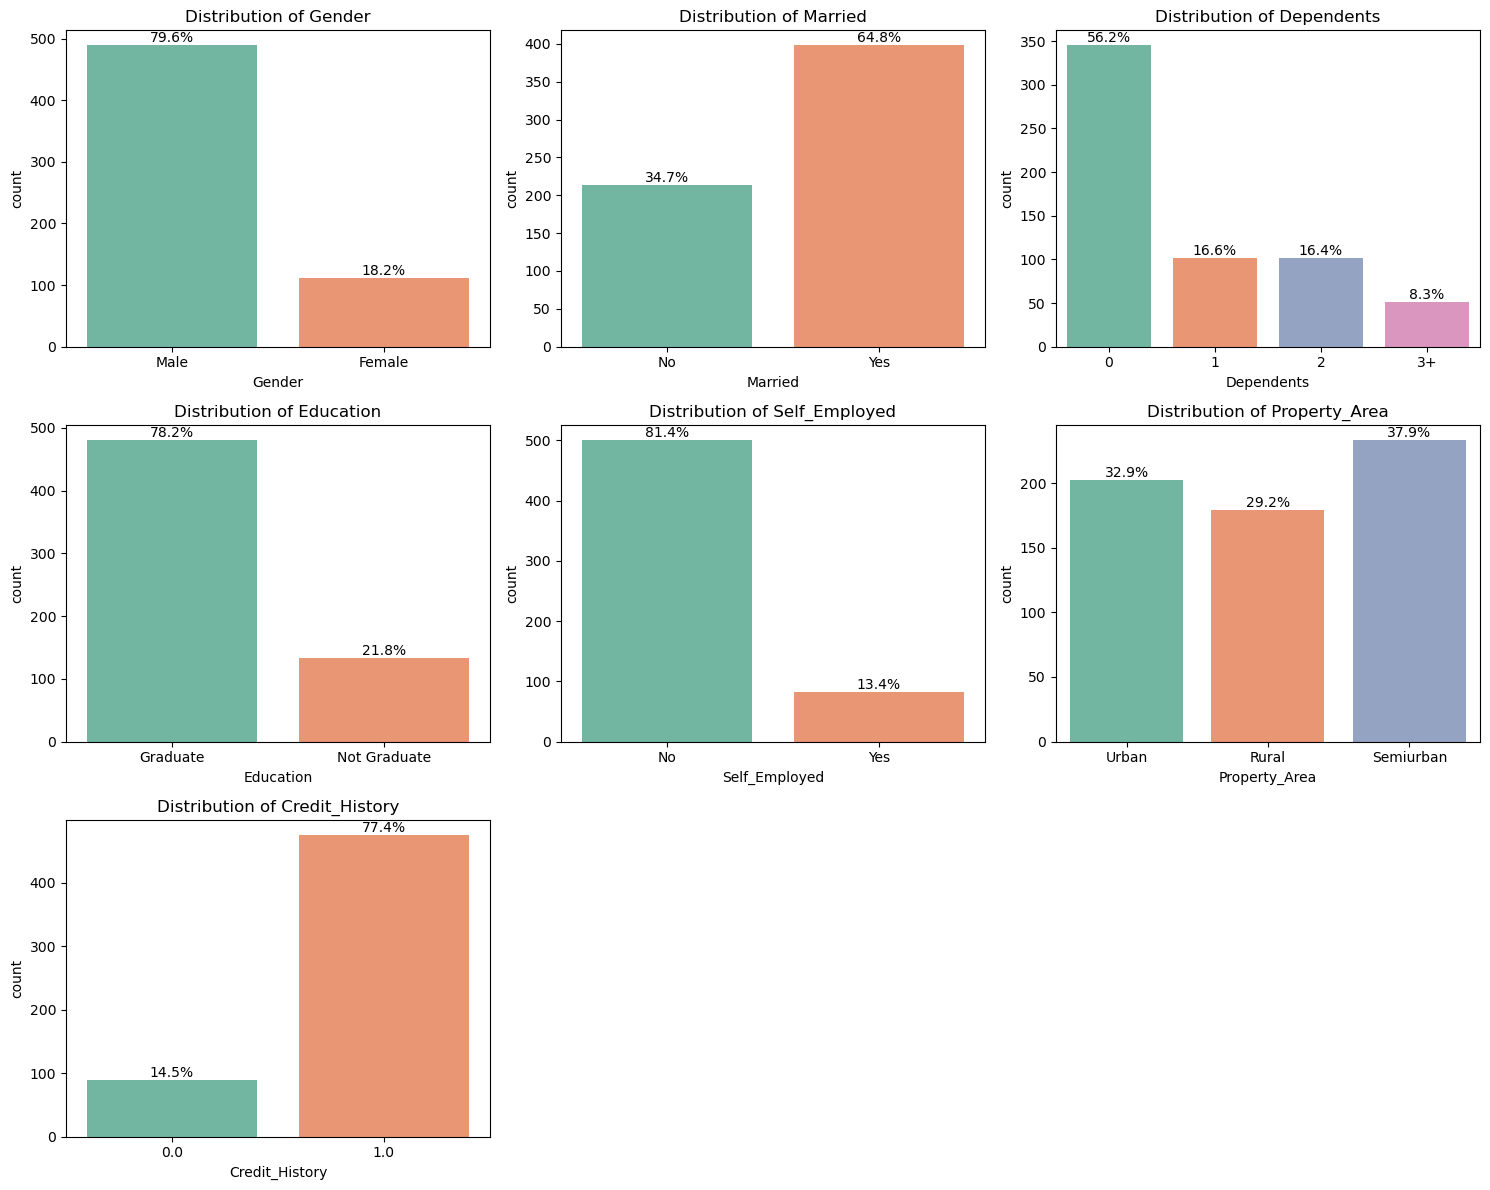

In [14]:
# List of categorical columns
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']

# Set up the figure for plotting with increased height
plt.figure(figsize=(15, 12))

# Loop through each categorical feature
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    
    # Set a unique color palette for each feature using a Seaborn color palette
    unique_values = train_data[column].nunique()
    palette = sns.color_palette("Set2", unique_values)  # Choose a different palette if preferred
    
    # Plot count plot with assigned colors and hue
    ax = sns.countplot(data=train_data, x=column, hue=column, palette=palette, dodge=False)
    plt.title(f'Distribution of {column}')
    
    # Check if legend exists and remove it if present
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
    
    # Calculate percentages and annotate, skipping zero percentages
    total = len(train_data)
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total
        if percentage > 0:  # Only annotate if percentage is greater than zero
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage:.1f}%', (x, y), ha='center', va='bottom', fontsize=10)
    
plt.tight_layout()
plt.show()


The count plots reveal key characteristics of the categorical features:

- `Gender` and `Married`: The majority of applicants are male and married.
- `Dependents`: There is a higher proportion of applicants without dependents, with fewer applicants reporting multiple dependents.
- `Education`: Most applicants are graduates.
- `Self_Employed`: Fewer applicants are self-employed, which might be a distinguishing characteristic among applicants.
- `Credit_History`: The majority of applicants have repaid their debts
- `Property_Area`: The distribution is fairly balanced across *Rural*, *Urban*, and *Semiurban* areas, potentially aiding in differentiating loan outcomes based on geographic context.

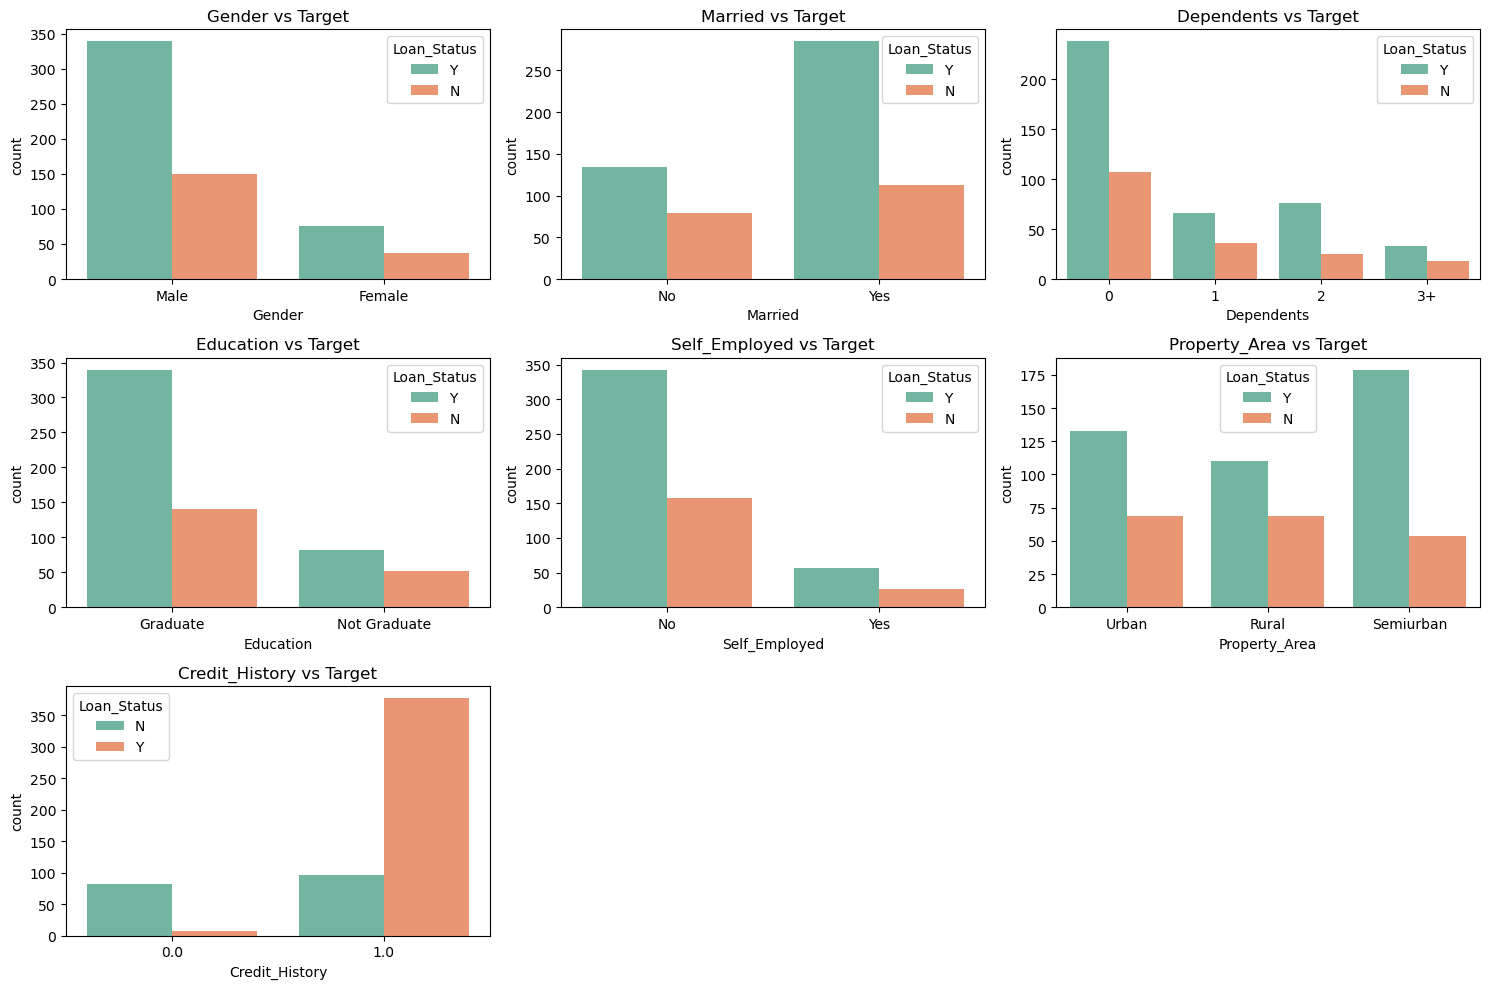

In [15]:
# Set color palette to only the first two colors of 'Set2'
palette = sns.color_palette("Set2")[:2]

# Countplots for categorical features with respect to target
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_data, x=column, hue='Loan_Status', palette=palette)  # Use palette here
    plt.title(f'{column} vs Target')

plt.tight_layout()
plt.show()

The count plots for categorical features reveal key relationships with loan approval status (`Loan_Status`). Here’s a summary of the insights:

- Male and married applicants have slightly higher loan approval rates, though this difference is minor.
- Applicants with fewer dependents appear to have slightly better approval rates.
- Graduates show higher loan approval rates than non-graduates.
- Non-self-employed applicants have higher approval rates.
- Applicants with a credit history (recorded as 1.0) show a significantly higher loan approval rate, indicating it is a strong predictor.
- Approval rates are higher in *Semiurban* areas compared to *Urban* and *Rural* areas. 

In [16]:
train_data.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area', 'Loan_Status', 'Total_Income', 'EMI',
       'Balance_Income'],
      dtype='object')

In [17]:
# Convert categrical variables into numerical value

le = LabelEncoder()
for col in categorical_features:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

train_data['Loan_Status'] = le.fit_transform(train_data['Loan_Status'])

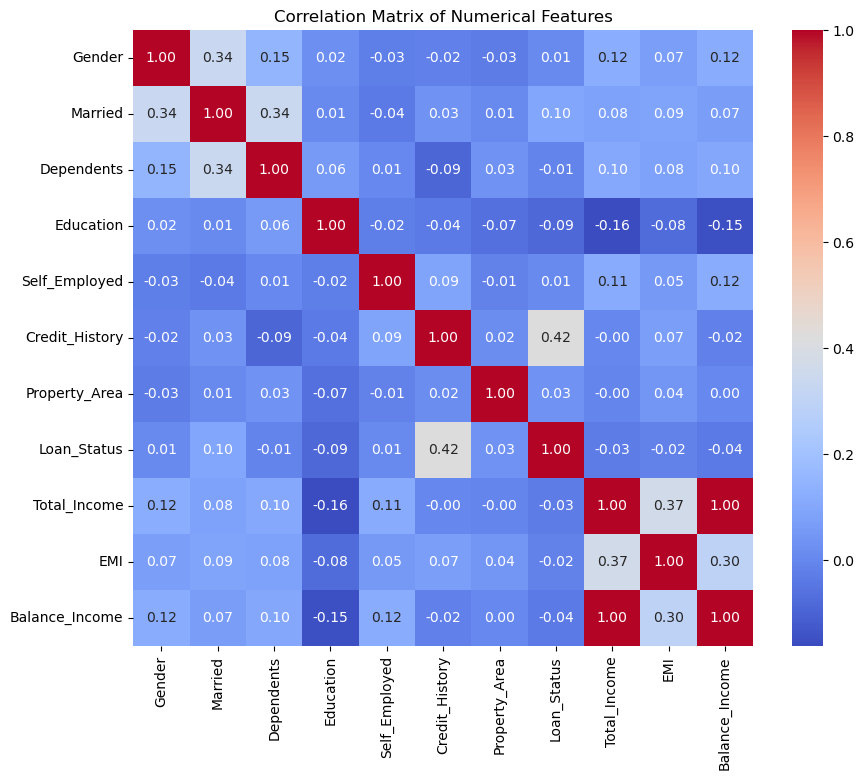

In [18]:
# Correlation matrix 

plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation matrix provides insights into the relationships between the features in the dataset with a focus on predicting the `Loan_Status`. Here are the key observations:

1. **Loan Status Correlations**:
   - `Credit_History` shows the highest positive correlation with `Loan_Status`, suggesting that credit history is a significant factor in determining loan approval.
   - Most other features have very low correlation with `Loan_Status`. For instance, `Total_Income`, `Balance_Income` and `Married` have very low correlation values, indicating that they are not strongly related to the loan approval outcome.
   - `Education`, `Self_Employed` and `Property_Area` have almost negligible correlation values with `Loan_Status`, suggesting they have minimal or no predictive power for this target variable in this dataset.
  
2. **Feature Interdependencies**:
   - `Total_Income` has a moderate positive correlation with `EMI`, indicating that as total income increases, EMI values also tend to increase, which is expected since individuals with higher incomes may be eligible for larger loans.
   - `Married` shows a mild positive correlation with `Gender` and `Dependents`, which could reflect a demographic pattern within the dataset where married individuals might often have dependents and be of a certain gender distribution.

3. **Insights for Predictive Modeling**:
   - Given the high correlation between `Credit_History` and `Loan_Status`, `Credit_History` should be a primary feature in the model.
   - Other features with minimal correlation may not significantly contribute to predicting `Loan_Status` and could be reconsidered during feature selection to snr larger loan amounts.

## Missing Value and Outlier Treatment
Identifying missing values and outliers aims to improve data quality by ensuring accuracy and reliability, as these issues can skew analysis and lead to incorrect conclusions. Addressing them helps build robust models and derive meaningful insights from the data.


In [19]:
# Check for missing values
train_data.isnull().sum()

Gender             0
Married            0
Dependents         0
Education          0
Self_Employed      0
Credit_History     0
Property_Area      0
Loan_Status        0
Total_Income       0
EMI               36
Balance_Income    36
dtype: int64

In [20]:
# Check for missing values
test_data.isnull().sum()

Gender             0
Married            0
Dependents         0
Education          0
Self_Employed      0
Credit_History     0
Property_Area      0
Total_Income       0
EMI               11
Balance_Income    11
dtype: int64

In [21]:
# Fill or drop missing values as necessary
# For example, filling categorical missing values with the mode and numerical with the median
for column in train_data.columns:
    if column in  categorical_features:
        train_data[column] = train_data[column].fillna(train_data[column].mode()[0])
        test_data[column] = train_data[column].fillna(train_data[column].mode()[0])
    else:
        train_data[column] = train_data[column].fillna(train_data[column].median())
        test_data[column] = train_data[column].fillna(train_data[column].median())

Apply the log transformation to right-skewed column distributions: smaller values are only minimally impacted, while larger values are substantially reduced, resulting in a distribution that more closely resembles a normal distribution. This transformation mitigates the influence of extreme values, making the distribution more symmetric and suitable for modeling.

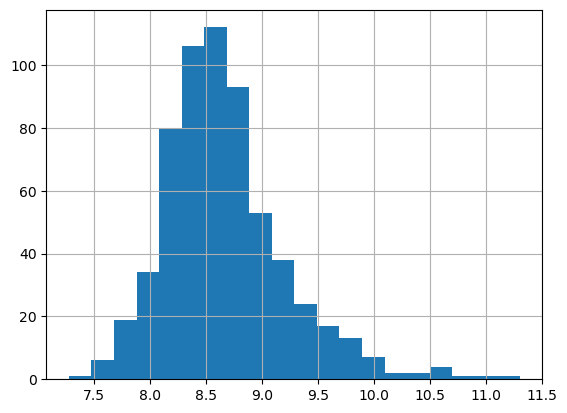

In [22]:
# Total Income
train_data['Total_Income_log'] = np.log(train_data['Total_Income']) 
train_data['Total_Income_log'].hist(bins=20) # effect of log transformation
test_data['Total_Income_log'] = np.log(test_data['Total_Income'])

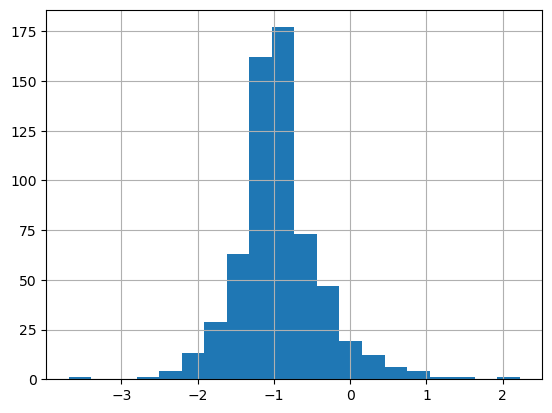

In [23]:
# EMI
train_data['EMI_log'] = np.log(train_data['EMI']) 
train_data['EMI_log'].hist(bins=20) # effect of log transformation
test_data['EMI_log'] = np.log(test_data['EMI'])

The `Balance_Income` features includes two negative values. Since a log transformation requires positive values, a constant equal to the absolute value of the minimum value of the balance income in the training and test datasets, plus 1, can be added to shift the data.

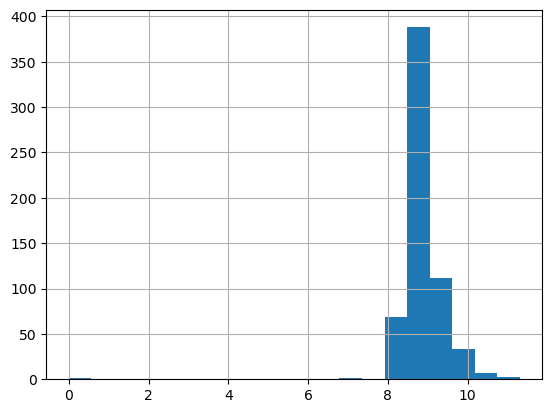

In [24]:
# CoapplicantIncome
min_value = min(train_data['Balance_Income'].min(), test_data['Balance_Income'].min())
c = abs(min_value) + 1
train_data['Balance_Income_log'] = np.log(train_data['Balance_Income'] + c) 
train_data['Balance_Income_log'].hist(bins=20) # effect of log transformation
test_data['Balance_Income_log'] = np.log(test_data['Balance_Income'] + c)

In [25]:
# Analisi outlier

In [26]:
# Remove the feature before log-transformation
train_data=train_data.drop(['Balance_Income', 'Total_Income', 'EMI'], axis=1)
test_data=test_data.drop(['Balance_Income', 'Total_Income', 'EMI'], axis=1)

## Machine Learning Model

When you have an imbalanced dataset, accuracy may not be the best metric to evaluate a Machine Learning (ML) model. A model that predicts only the majority class (1) would achieve about 70% accuracy without actually learning anything meaningful about the minority class (0). Furthermore, accuracy does not account for the distribution between the two classes, making it less informative in imbalanced scenarios.

F1 Score will be used to compare the performancce of differente ML model and is defined as the harmonic mean of precision and recall.
Precision tells you how often the model is correct when it predicts class 1, whereas, recall helps to see how well the model is identifying class 1 correctly.

In [27]:
# Prepare data for feeding into the model
X = train_data.drop('Loan_Status', axis=1) 
X_test = test_data.copy()
y = train_data.Loan_Status.astype(int)

# Initialize the scaler
scaler = StandardScaler()

# Apply the scaler only to the numerical columns in X
numerical_columns_log = ['Total_Income_log', 'EMI_log', 'Balance_Income_log']
X[numerical_columns_log] = scaler.fit_transform(X[numerical_columns_log])
X_test[numerical_columns_log] = scaler.transform(X_test[numerical_columns_log])

# Define 10-fold stratified cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=27)

A K-Nearest Neighbors model is trained as a baseline to compare the performance against more advanced models. 

In [28]:
# K-Nearest Neighbors (KNN)
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, knn_params, cv=skf, scoring='f1')
knn_grid.fit(X, y)

print("Best KNN Parameters:", knn_grid.best_params_)
print("Best KNN F1 Score:", knn_grid.best_score_)

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best KNN F1 Score: 0.8424416306821089


In [29]:
# Support Vector Machine (SVM)
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC()
svm_grid = GridSearchCV(svm_model, svm_params, cv=skf, scoring='f1')
svm_grid.fit(X, y)
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM F1 Score:", svm_grid.best_score_)

Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM F1 Score: 0.8766405501343781


In [30]:
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20]
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=skf, scoring='f1')
rf_grid.fit(X, y)
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest F1 Score:", rf_grid.best_score_)

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 150}
Best Random Forest F1 Score: 0.8767269252729839


In [31]:
# XGBoost parameters
xgb_params = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10]
}
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=skf, scoring='f1')
xgb_grid.fit(X, y)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost F1 Score:", xgb_grid.best_score_)

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost F1 Score: 0.8766405501343781


SVM, Random Forest, and XGBoost all have an F1 score higher than KNN’s F1 score of 0.8424. 
Random Forest is the top performer here, albeit by a very small margin over SVM and XGBoost. 
Random Forest is easier to interpret than SVM and XGBoost because one can visualize the decision trees and assess feature importance. 
Given its high interpretability, Random Forest is chosen as the best model.

### Feature Importance Analysis

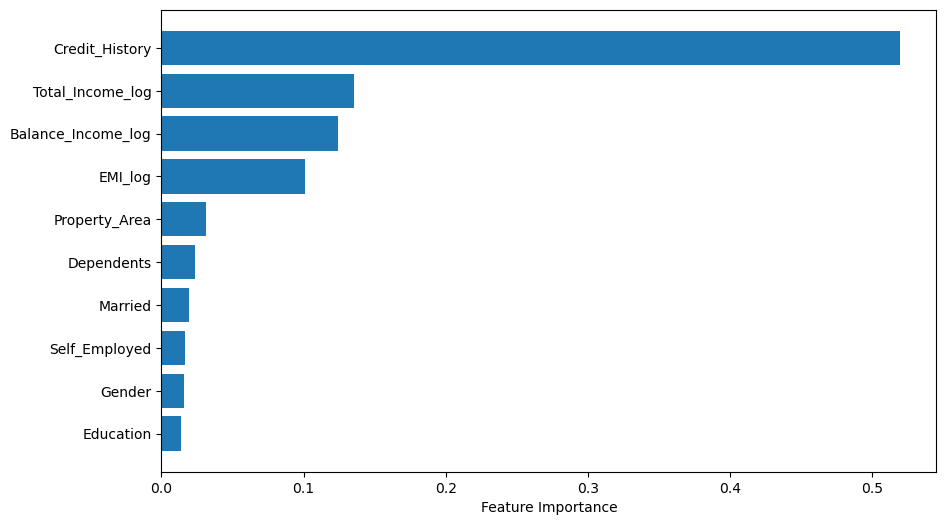

In [32]:
# Get the best Random Forest model from GridSearchCV
best_rf_model = rf_grid.best_estimator_

# Retrieve feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel("Feature Importance")
plt.show()

`Credit_History`: This feature has the highest importance, suggesting that a customer's credit history significantly impacts the model's prediction, possibly indicating strong predictive power regarding loan approvals or similar financial decisions.

`Total_Income_log` and `Balance_Income_log`: These income-related features also show notable importance, though they are less influential than Credit_History. They suggest that total and balanced income levels contribute significantly to the model’s decisions.

`EMI_log`: The EMI feature holds moderate importance, indicating that the model considers the borrower's EMI burden in its predictions. Feature engineering assisted the model in forecasting the target variable. 

`Property_Area` and `Dependents`: These categorical variables have lower importance but still contribute to the model. They might represent factors such as urban vs. rural locations or family obligations affecting loan repayment capacity.

`Married`,`Self_Employed`,`Self_Employed` and `Education`: These features have the least importance, indicating minimal impact on the model’s output. It suggests that marital status, employment type, gender, and education level are less critical for the model's predictions.

The model emphasizes financial history and income as primary predictors for lending decisions, while demographic features like gender, marital status, education, property area, and self-employed status are less influential and carry a higher risk of bias. 

**Recommendations for Removal of Demographic Features**
- Gender: Low predictive power and potential for gender-based discrimination justify its removal.
- Marital Status: Minimal relevance to creditworthiness; its removal helps avoid bias against single or non-traditional household setups.
- Education: Does not directly impact repayment ability; removing it promotes fairness regardless of educational background.
- Property Area: Could lead to geographic or socioeconomic bias; excluding it prevents discrimination based on location.
- Self-Employed Status: Might disadvantage non-traditional workers, though it has limited influence on creditworthiness.


**Ethical and Practical Justifications**
- Fairness and Transparency: Removing these features supports ethical lending and aligns with fair lending practices, as they do not significantly affect model performance.
- Explainability: Transparency about key features enhances trust and helps applicants understand eligibility factors.
- Fairness Audits: Regular audits can detect and address potential biases, ensuring ongoing compliance with ethical standards and fair treatment across demographics.

In [33]:
# Retrain the Random forest model with only financial history and income features

feature_column_new = ['Credit_History', 'Total_Income_log', 'EMI_log', 'Balance_Income_log']

X_new = X[feature_column_new]
X_test_new = X_test[feature_column_new]

# Retrieve the best parameters from the initial GridSearchCV
best_rf_params = rf_grid.best_params_

# Initialize a new RandomForestClassifier using the best parameters
rf_model = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    random_state=42
)

# Fit the model to the new data X1, y1
rf_model.fit(X_new, y)

RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=150,
                       random_state=42)

In [34]:
# Save the model as a pickle in a file
joblib.dump(rf_model, 'rf_model.pkl')
# Save the scaler as a pickle in a file  
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### Understanding Model Predictions

The SHAP library is used to explain the classification of a loan application as either "approved" or "rejected" by identifying the contributions of specific features for that particular instance. This capability is crucial for financial institutions to build trust with their customers. By offering clear and understandable explanations for loan approval or rejection decisions using SHAP values, institutions can enhance transparency, trustworthiness, and customer satisfaction.

In [35]:
# Fit the explainer
explainer = shap.Explainer(rf_model.predict, X_test_new)

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_new)

In [36]:
# Predict on X_test_new
y_pred = rf_model.predict(X_test_new.iloc[[9]])
print('The model prediction is', y_pred[0])

The model prediction is 0


The Waterfall plot in the SHAP library is a visualization that helps explain the contribution of individual features to a specific prediction for a single instance (e.g., a single row of your dataset). It is particularly useful for understanding how the model arrives at a specific prediction by visualizing the impact of each feature value.

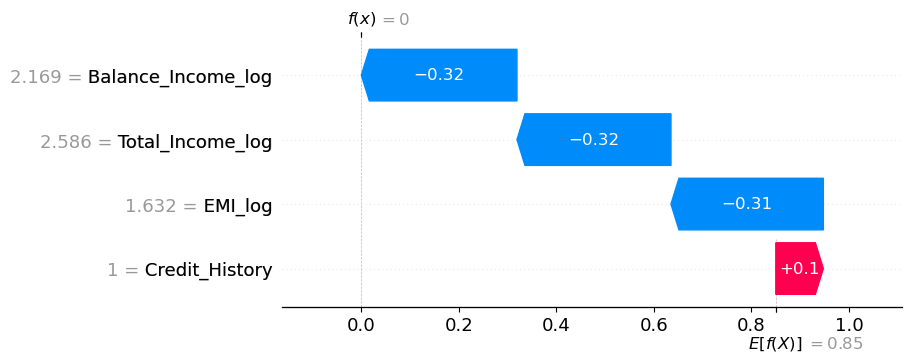

In [37]:
shap.plots.waterfall(shap_values[9])

Each bar represents a feature, and the direction of the bar (left or right) indicates whether the feature has a negative or positive impact on the prediction.

- Features like `Balance_Income_log`, `Total_Income_log`, and `EMI_log` have significant negative contributions, pulling the prediction lower.
- `Credit_History` has a positive contribution, slightly increasing the prediction.
- The combined effect of all these features leads to the rejection of the loan.

In [38]:
# For completeness, these are the values of the original features.
test_data_original.iloc[9]

Gender                       Male
Married                        No
Dependents                      0
Education            Not Graduate
Self_Employed                  No
ApplicantIncome              2400
CoapplicantIncome            2400
LoanAmount                  123.0
Loan_Amount_Term            360.0
Credit_History                1.0
Property_Area           Semiurban
Total_Income                 4800
EMI                      0.341667
Balance_Income        4458.333333
Name: 9, dtype: object